<a href="https://colab.research.google.com/github/markus-weiss/AVGAN/blob/master/AVGAN_8_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install and connect

In [0]:
!pip install tensorflow-gpu==2.0.0-beta0
!pip install imageio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Change Directory to your Script
cd /content/drive/My Drive/Colab Notebooks/AVGAN/

/content/drive/My Drive/Colab Notebooks/AVGAN


In [4]:
!ls


audio_input	       complete_output_at_0001.png  image_input_3
audio_output	       _GIF_OUTPUT		    image_output
_AVGAN_1-3TrainResult  image_at_epoch_0001.png	    training_checkpoints
_AVGAN_Versions        image_input


#Imports

In [0]:
import tensorflow as tf
tf.__version__

import keras
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Concatenate, Dense, LSTM, Flatten, RepeatVector, TimeDistributed, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Bidirectional, GaussianNoise, BatchNormalization
from keras.layers import CuDNNLSTM as LSTM


import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import matplotlib.image as mpimg
from IPython import display


#DATA READIN


##Audio ReadIn

In [107]:
def getListOfFiles(dirName):
  # create a list of file and sub directories 
  # names in the given directory 
  listOfFile = os.listdir(dirName)
  allFiles = list()
  # Iterate over all the entries
  for entry in listOfFile:
      # Create full path
      fullPath = os.path.join(dirName, entry)
      # If entry is a directory then get the list of files in this directory 
      if os.path.isdir(fullPath):
          allFiles = allFiles + getListOfFiles(fullPath)
      else:
          allFiles.append(fullPath)

  return allFiles
  
  
# Not stable is pre alpha cause when the pictures not directly inumeratet 
# [102. 150. 102.   3.] this output is not good but if you print out the data concat read in you find the error but why
# for item in audioList:
#  print(item)


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

  
def From6to2Dimensions(log,phase):
   
  log = rgb2gray(log) 
  phase = rgb2gray(phase) 

  reshapeAudioImage = np.ndarray((224,224,2))
  reshapeAudioImage[:,:,0] = log[:,:]
  reshapeAudioImage[:,:,1] = phase[:,:]
  
  return reshapeAudioImage
  



def ConcatAllPairsInFolder(audiolist):
  n = 1
  concatAudioImage = [len(audioList)/2,224,224,6]
  for item in audioList:
    #print(n)

    import re
    r = re.compile('.*_' + str(n) +'.jpg')
    pair = list(filter(r.match, audioList)) # Read Note
    #print(pair[0]," ",pair[1])
    #print(pair)
    

    import cv2 
    log     = cv2.imread(pair[0])  
    phase   = cv2.imread(pair[1])

    #import tensorflow as tf
    # dimension 2 IS RIGHT ????
    LogPhaseCon = tf.concat([log,phase],2)
    #print(LogPhaseCon.shape)

    concatAudioImage[n-1] = From6to2Dimensions(log,phase)
    #print(np.shape(concatAudioImage[n-1]))


    if n >= len(audioList)/2:
      return concatAudioImage
      break
    else:
      n=n+1
      


def ConvertToTensor(concatImageAudioList, audioimageCount):
  import numpy as np
  ndarray = np.ones([audioimageCount,224,224,2])
  
  # Convert color to grey 6 - 2 channel

  ndarray[0,:,:,:] = concatImageAudioList[0]

  n=0
  for item in concatImageAudioList:
    ndarray[n,:,:,:] = concatImageAudioList[n]
    n=n+1

  tensor = tf.add(ndarray, 1)


  return tf.convert_to_tensor(ndarray, np.float32)



audioFolder = 'audio_input/'
audioList = getListOfFiles(audioFolder)
concatImageAudioList = ConcatAllPairsInFolder(audioList)
audioimageCount = len(concatImageAudioList)

audio_dataset = ConvertToTensor(concatImageAudioList,audioimageCount)

print(audio_dataset.shape)


(4, 224, 224, 2)


##Image ReadIN


In [108]:
def GetListOfFiles(dirName):
  # create a list of file and sub directories 
  # names in the given directory 
  listOfFile = os.listdir(dirName)
  allFiles = list()
  # Iterate over all the entries
  for entry in listOfFile:
      # Create full path
      fullPath = os.path.join(dirName, entry)
      # If entry is a directory then get the list of files in this directory 
      if os.path.isdir(fullPath):
          allFiles = allFiles + getListOfFiles(fullPath)
      else:
          allFiles.append(fullPath)

  return allFiles

def ImageReadIn(image_list):
  image_array = [len(image_list),600,800,3]
  for item in image_list:
    import cv2 
    image = cv2.imread(item)
    reshaped_image = image
    image_array[0] = image

  return image_array

def ConvertToTensor(image_list, image_count):
  import numpy as np
  ndarray = np.ones([image_count,600,800,3])

  ndarray[0,:,:,:] = image_list[0]

  n=0
  for item in image_list:
    ndarray[n,:,:,:] = image_list[n]
    n=n+1

  # TO CHECK THAT THE DATA IS RIGHT
  #print(ndarray[:,0,0,0])

  # CONVERT A NUMPY ARRAY TO A TENSOR
  img_tensor = tf.add(ndarray, 1)
  tensor_reshape = tf.image.resize(img_tensor, [224, 224])

  return tf.convert_to_tensor(tensor_reshape, np.float32)


  
image_data_root = "image_input_3/"
image_list = GetListOfFiles(image_data_root)
image_data_array = ImageReadIn(image_list)
image_count = len(image_list)

image_dataset = ConvertToTensor(image_data_array,image_count)

print(image_dataset.shape)




(4, 224, 224, 3)


#Generator


In [127]:
# Generate to streams in the generator , de concatenation in the generator
# upconv to (None, 28, 28, 256) and the split it in two streams inside 
# resphape an reconcate

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(6272,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 128)))
    assert model.output_shape == (None, 7, 7, 128) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 256)
    
    for layer in model.layers:
      aA=layer.output_shape
      bA=layer.output
      #print(aA)
      #print(bA)
    
    return model
  
noise = tf.random.normal([1, 6272])
generator = make_generator_model()
generated_model = generator(noise, training=False)


generated_model.shape


TensorShape([1, 28, 28, 256])

In [0]:
def deConcatModel(model):
   
  deConcatedModelAudio = np.ones([28,28,128])
  deConcatedModelImage = np.ones([28,28,128])
  split0, split1 = tf.split(model, num_or_size_splits=2, axis=3)
  tf.shape(split0)
  tf.shape(split1)

  deConcatedModelAudio = split0
  deConcatedModelImage = split1
  return deConcatedModelAudio , deConcatedModelImage

In [0]:

def deConvolution_Audio():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 128]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) 

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 56, 56, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 112, 112, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())    

    model.add(layers.Conv2DTranspose(2, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 224, 224, 2)

    for layer in model.layers:
      aA=layer.output_shape
      bA=layer.output
      #print(aA)
      #print(bA)
    
    return model
  
ndarray = np.ones([4,28,28,128])
ndarray = tf.cast(ndarray, 'float32')
deConvolution_Audio = deConvolution_Audio()
deConvolution_Audio_Image = deConvolution_Audio(ndarray)



In [0]:

def deConvolution_Image():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 128]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) 

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 56, 56, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 112, 112, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())    

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 224, 224, 3)
    
    for layer in model.layers:
      aA=layer.output_shape
      bA=layer.output
      #print(aA)
      #print(bA)
    
    return model
  
ndarray = np.ones([4,28,28,128])
ndarray = tf.cast(ndarray, 'float32')
deConvolution_Image = deConvolution_Image()
deConvolution_Image_var = deConvolution_Image(ndarray)

 

#Discriminator

In [131]:
def convolute_Image():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(32, (3,3), strides = (1,1), padding = 'same', input_shape= [224,224,3]))
  model.add(layers.LeakyReLU())

  model.add(layers.MaxPooling2D(2, 2))
  model.add(layers.Conv2D(64, (3,3), strides = (1,1), padding = 'same'))
  model.add(layers.LeakyReLU())
  
  model.add(layers.MaxPooling2D(2, 2))
  model.add(layers.Conv2D(128, (3,3), strides = (1,1), padding = 'same'))
  model.add(layers.LeakyReLU())
  model.add(layers.MaxPooling2D(2, 2))
  for layer in model.layers:
    aA=layer.output_shape
    bA=layer.output
    #print(aA)
    #print(bA)
  
  return model

convolute_Image = convolute_Image()
image_decision = convolute_Image(image_dataset)
print (image_decision)


#image_dataset = np.ones([4,224,224,3])
#image_dataset = tf.convert_to_tensor(image_dataset, np.float32)


#convolute_image = convolute_Image()
#image_decision = convolute_image(image_dataset)




tf.Tensor(
[[[[-6.43558884e+00  3.72131424e+01 -1.81497180e+00 ...  5.63227940e+00
     1.30190153e+01  1.40344200e+01]
   [-4.96656656e+00  2.59713192e+01 -3.37009263e+00 ...  1.42417812e+00
     1.43324537e+01  2.75190997e+00]
   [-4.84245157e+00  2.59833927e+01 -3.26498580e+00 ...  1.21009254e+00
     1.41203966e+01  2.92510676e+00]
   ...
   [-4.83521700e+00  1.88634949e+01 -3.53243685e+00 ... -7.12907434e-01
     8.76300049e+00 -1.40318441e+00]
   [-5.15850306e+00  1.90479298e+01 -3.63101077e+00 ... -4.94255692e-01
     1.08949089e+01 -1.12420595e+00]
   [-3.00697589e+00  2.42484360e+01 -2.22655916e+00 ...  1.64244890e+00
     1.36669369e+01 -1.92108899e-01]]

  [[-9.29141712e+00  3.40398331e+01 -7.07545900e+00 ... -3.97564292e-01
     1.25287180e+01 -6.71788645e+00]
   [-6.93064117e+00  2.28982868e+01 -7.25251961e+00 ... -1.34493542e+00
     1.83704109e+01 -7.10172796e+00]
   [-6.73644638e+00  2.29064140e+01 -7.08625412e+00 ... -1.27858078e+00
     1.84306774e+01 -6.99657631e+00]

In [0]:
def convolute_Audio():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(32, (3,3), strides = (1,1), padding = 'same', input_shape= [224,224,2]))
  model.add(layers.LeakyReLU())

  model.add(layers.MaxPooling2D(2, 2))
  model.add(layers.Conv2D(64, (3,3), strides = (1,1), padding = 'same'))
  model.add(layers.LeakyReLU())
  
  model.add(layers.MaxPooling2D(2, 2))
  model.add(layers.Conv2D(128, (3,3), strides = (1,1), padding = 'same'))
  model.add(layers.LeakyReLU())
  model.add(layers.MaxPooling2D(2, 2))
  for layer in model.layers:
    aA=layer.output_shape
    bA=layer.output
    #print(aA)
    #print(bA)
  
  return model


#audio_dataset = np.ones([4,224,224,2])
#audio_dataset = tf.convert_to_tensor(audio_dataset, np.float32)
#audio_dataset = tf.data.Dataset.from_tensor_slices(audio_dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

convolute_Audio = convolute_Audio()
audio_decision = convolute_Audio(audio_dataset)
print (audio_decision)

#convolute_Audio = convolute_Audio()
#audio_decision = convolute_Audio(audio_dataset)
#print(audio_decision.shape)

In [116]:

def convolutions_concatenation(audio_conv,image_conv):
  concatenation = tf.concat([audio_conv, image_conv], axis=3)
  return concatenation

convolutions_concatenation = convolutions_concatenation(audio_decision,image_decision)

print(convolutions_concatenation.shape)


(4, 28, 28, 256)


In [0]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 256]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    for layer in model.layers:
      aA=layer.output_shape
      bA=layer.output
      #print(aA)
      #print(bA)
    model.add(layers.Dense(1))

    return model
  

discriminator = discriminator_model()
output = discriminator(convolutions_concatenation)
print (output)
print(output.shape)



#Train Dataset


In [0]:
noise_dim = 6272
num_examples_to_generate = 1
BUFFER_SIZE = 60
BATCH_SIZE = 256
#decision = Final_discriminator_model(generated_image)
#print (decision)

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)



def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
  
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
  
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)



# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

@tf.function
def train_step(train_concat_dataset,audio_dataset,image_dataset):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  #print(audio_dataset)
  #print(image_dataset)
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    # Generator
    generated_data = generator(noise, training=True)
    audio_concat, image_concat = deConcatModel(generated_data)

    #audio_deconv = deConvolution_Audio(audio_concat)
    #image_deconv = deConvolution_Image(image_concat)
    
    #convolute_Audio(audio_deconv)
    #convolute_Image(image_deconv)
    
    #conv_generated_data = convolutions_concatenation(convolute_Audio,convolute_Image)
    #conv_generated_data = tf.concat([convolute_Audio, convolute_Image], axis=3)
  
    #print('audio_deconv',audio_deconv)
    #print('image_deconv',image_deconv)
  
    # Discriminator
    discriminator_data = train_concat_dataset
  
  
    # Give to 
    # 28*28*265
    real_output = discriminator(discriminator_data, training=True)
    
    #
    fake_output = discriminator(generated_data, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    print('disc_loss',disc_loss)

    
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  

    
def train(audio_dataset, image_dataset, epochs):
    
    
    
  for epoch in range(epochs):
    start = time.time()
    
    for image_batch in image_dataset:
      #print('train',audio_dataset.shape)
      #print('train',image_dataset.shape)     
      
      audio_conv = convolute_Image(audio_dataset)  
      image_conv = convolute_Image(image_dataset)  
      
      
      concatenation = tf.concat([audio_conv, image_conv], axis=3)
      
      #print(concatenation.shape)
      
      #train_concat_dataset = convolutions_concatenation(audio_conv,image_conv)
      
      train_step(concatenation,audio_dataset, image_dataset)

      
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 500 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator , epochs, seed)
  





In [0]:
def generate_and_save_images(model, epoch, test_input):
  

  predictions = model(test_input, training=False)

  
  audio_deconcat, image_deconcat = deConcatModel(predictions)
  audio_deconv = deConvolution_Audio(audio_deconcat)
  image_deconv = deConvolution_Image(image_deconcat)

  
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)


  
  
  
  pufferImg = np.ndarray((224,224,3))
  pufferImg = image_deconv[0,:,:,:]

  #print(pufferImg[0,0,0])

  #pufferPhase = np.ndarray((224,224))
  #pufferPhase = audio_deconv[0,:,:,0] #* 127.5 + 127.5
  
  #pufferLog = np.ndarray((224,224))
  #pufferLog = audio_deconv[0,:,:,1] #* 127.5 + 127.5
   
  
  plot_size = 4
  
  
  # IMAGE    
  plt.figure(figsize=(plot_size,plot_size))
  plt.title('RGB-Image')
  plt.imshow((pufferImg))
  plt.axis('off')
  #plt.savefig('./image_output/image_at_epoch_{:04d}.png'.format(epoch))
    
    
  # AUDIO
  ## PHASE
  #plt.figure(figsize=(plot_size,plot_size))
  #plt.title('PHASE-IMAGE')  
  #plt.imshow(pufferPhase, cmap='gray')
  #plt.axis('off')
  #plt.savefig('./audio_output/phase_at_epoch_{:04d}.png'.format(epoch))

  ## LOG_MAGNITUDE
  #plt.figure(figsize=(plot_size,plot_size))
  #plt.title('LOG-IMAGE')
  #plt.imshow(pufferLog, cmap='gray')
  #plt.axis('off')
  #plt.savefig('./audio_output/log_at_epoch_{:04d}.png'.format(epoch))
  
  
  plt.show()


  

In [0]:
EPOCHS = 1000

W0725 12:58:28.086120 139954328741760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


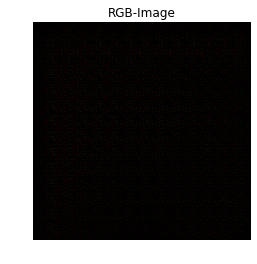

Time for epoch 245 is 1.9213049411773682 sec


In [0]:
%%time
train(image_dataset, image_dataset, EPOCHS)

In [20]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
anim_file = 'AVGAN.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  #filenames = glob.glob('image*.png')
  filenames = glob.glob('./image_output/image*.png')
  #filenames = glob.glob('./audio_output/log*.png')
  #filenames = glob.glob('./audio_output/phase*.png')
  
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)